<a href="https://colab.research.google.com/github/IrfanChairurrachman/cats-vs-dogs/blob/master/KC_Final_Project.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project 4A

Nama Kelompok:

1. 18106050005 - Farah Aura Dody Effendi
2. 18106050016 - Irfan Chairurrachman
3. 18106050022 - Galih Redha Saputra

---


## Import Module, Menggunakan dan Mengecek GPU

Cara menggunakan GPU pada Google Colab:

- Edit -> Notebook settings
- Pilih GPU pada "Hardware Accelerator"

In [1]:
import os       # Membantu manajemen file dan folder
import zipfile  # Untuk mengekstrak file ekstensi zip
import random   
import tensorflow as tf     # library tensorflow untuk pelatihan model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # ImageDataGenerator untuk augmentasi gambar
from shutil import copyfile

In [2]:
# Cek apakah GPU terhubung atau tidak
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU tidak ditemukan')
print('GPU terhubung: {}'.format(device_name))

GPU terhubung: /device:GPU:0


## 1. Persiapan Data

Sesi persiapan data kucing dan anjing, mulai dengan mengimport module-module yang diperlukan dalam pengembangan model Machine Learning. Salah satunya adalah library Tensorflow

### Mengunduh Data

![kaggle](inventory/kaggle.png "kaggle")

Mengunduh data dengan perintah `wget` di terminal dan menyimpannya dalam folder `/content`.

Dataset ini mempunyai 25.000 gambar yang mempunyai folder training dan folder validasi untuk masing-masing kelas.

(karena saat ini masih percobaan maka menggunakan data filter dari google, dengan data lebih sedikit, yaitu 3000 gambar)

In [3]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/content/cats-and-dogs.zip"

local_zip = '/content/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

--2021-01-20 10:18:46--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.33.180.114, 2600:1408:8c00:787::e59, 2600:1408:8c00:78e::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.33.180.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/content/cats-and-dogs.zip’

/content/cats-and-d 100%[===================>] 786.68M   145MB/s    in 5.7s    

2021-01-20 10:18:52 (139 MB/s) - ‘/content/cats-and-dogs.zip’ saved [824894548/824894548]



### Direktori Data

Menyimpan path file dan folder dalam variabel yang telah ditentukan. 

Disini juga dilakukan pemisahan antara data pelatihan yang akan dipakai oleh model untuk belajar dan data validasi untuk mengukur kemampuan model dengan memberikan data yang belum pernah diliat ketika belajar.

In [4]:
# Direktori utama
base_dir = '/content/PetImages'

# Direktori gambar kucing
cats_dir = os.path.join(base_dir, 'Cat')

# Direktori gambar Anjing
dogs_dir = os.path.join(base_dir, 'Dog')

# Mengambil semua nama file dalam masing-masing direktori
cat_fnames = os.listdir(cats_dir)
dog_fnames = os.listdir(dogs_dir)

### Isi Data

Menampilkan 4 gambar kucing dan 4 gambar anjing yang terpilih (secara berurutan) dengan menggunakan library `matplotlib`.

In [5]:
%matplotlib inline

# Import module matplotlib untuk menampilkan gambar
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Untuk menampilkan gambar dengan konfigurasi 2x4.
nrows = 2
ncols = 4

pic_index = 0 # Indeks untuk iterasi setiap gambar

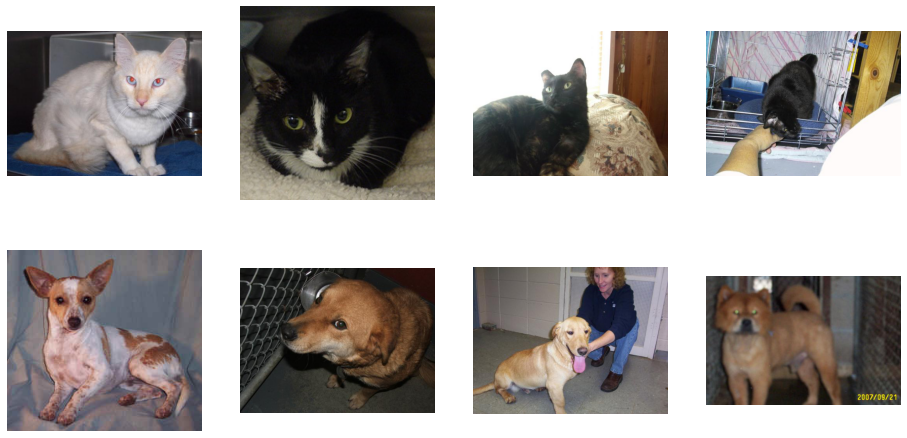

In [6]:
# Menyiapkan matplotlib fig (figura/canvas) dengan 2x4 gambar.
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=4

# Menyimpan ke dalam list nama file yang akan ditampilkan
next_cat_pix = [os.path.join(cats_dir, fname) 
                for fname in cat_fnames[pic_index-4:pic_index] 
               ]

next_dog_pix = [os.path.join(dogs_dir, fname) 
                for fname in dog_fnames[pic_index-4:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  # Menampilkan gambar
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Pembersihan Data

Pembersihan data penting dilakukan agar tidak terjadi error saat pelatihan. Selain itu, data yang bersih dan baik akan sangat berpengaruh terhadap performa model.

In [7]:
from PIL import Image

# Fungsi untuk membersihkan data
def clean_data(SOURCE):
    # Iterasi setiap file dalam direktori
    for filename in os.listdir(SOURCE):
        file = SOURCE + '/' + filename
        # mencoba verifikasi gambar
        try:
            img = Image.open(file)
            img.verify()
        except IOError:
            # Jika error, maka akan menghapus file
            print(file + " bukan gambar atau size file = 0")
            os.remove(file)

# membersihkan direktori Kucing
clean_data(cats_dir)
# membersihkan direktori Anjing
clean_data(dogs_dir)

/content/PetImages/Cat/666.jpg bukan gambar atau size file = 0
/content/PetImages/Cat/Thumbs.db bukan gambar atau size file = 0


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

/content/PetImages/Dog/Thumbs.db bukan gambar atau size file = 0
/content/PetImages/Dog/11702.jpg bukan gambar atau size file = 0


## 2. Model

Membuat model dengan input ukuran 150x150 pixel (3 byte warna). Ini dilakukan karena model hanya menerima input dengan ukuran persegi (tinggi dan lebar harus sama).

Layer-layer model terdiri dari operasi konvolusi serta maxpooling. Ini dilakukan untuk mengekstrak fitur yang terdapat pada gambar, sehingga dapat mengurangi ukuran gambar tanpa harus kehilangan informasi penting pada gambar.

Terlihat hasil `model.summary()`, setiap kali melakukan konvolusi maka tepi gambar akan berkurang dan menghasilkan pixel baru dengan informasi yang sama.

Begitu pula setiap melakukan maxpooling, gambar akan kehilangan 3/4 ukurannya.

In [8]:
# model yang terdiri dari beberapa layer
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Menampilkan summary/keterangan dari model
model.summary()

# compile model
model.compile(loss='binary_crossentropy', # binary karena 2 kelas (biner)
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Convolution

Konvolusi dilakukan untuk mengekstrak informasi penting yang berada dalam gambar.

Konvolusi melakukan operasi tetangga dengan matriks kernel 3x3. Sehingga tepi gambar semula tidak akan mengalami operasi.

![Conv1](https://github.com/IrfanChairurrachman/cats-vs-dogs/blob/master/inventory/conv1.png?raw=1)

![Conv2](https://github.com/IrfanChairurrachman/cats-vs-dogs/blob/master/inventory/conv2.png?raw=1)


### Maxpooling

Maxpooling mengambil nilai terbesar setiap 2x2 piksel pada gambar. Sehingga ukuran gambar hanya menjadi 25% dari ukuran gambar semula, tanpa mengurangi informasi penting pada gambar.

![pooling](https://github.com/IrfanChairurrachman/cats-vs-dogs/blob/master/inventory/pooling.png?raw=1)

### Generator

Generator membantu model dan komputer dalam proses pelatihan. Pada `ImageDataGenerator(rescale=1./255)` adalah membagi semua piksel dengan pembagi 255. Sehingga nilai piksel berada diantara 0-1 (dengan alasan memudahkan komputer dalam beroperasi).

`class_mode` menggunakan `binary` karena pelatihan ini untuk mengklasifikasikan 2 kelas, yaitu kelas anjing dan kelas kucing. Jika kelas lebih dari 2, biasanya menggunakan `categorical`. 

In [9]:
# Semua piksel akan dibagi 255
train_datagen = ImageDataGenerator(rescale=1./255,
                                # membagi direktori menjadi 20% data validasi (80% train)
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        base_dir,  # Direktori utama
        target_size=(150, 150),  # Besar Input harus sama besar dan dijadikan 150x150
        batch_size=20,
        # karena klasifikasi 2 kelas, maka menggunakan binary
        class_mode='binary',
        subset = 'training') # Penentuan sebagai data latih

validation_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        subset = 'validation') # Penentuan sebagai data latih

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


**Callback**

Callback berfungsi untuk menghentikan pelatihan ketika target akurasi telah tercapai. Ini dilakukan untuk mencegah terjadinya pelatihan yang banyak namun tingkat akurasi mengalami stagnan.

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92):
      print("\nAkurasi di atas 92%, hentikan pelatihan!")
      self.model.stop_training = True

callbacks = myCallback()

## 3. Pelatihan

Melakukan pelatihan model dengan 50x `epochs` (pelatihan). Serta memeriksa kemampuan model dengan melihat `val_acc`, yaitu tingkat keberhasilan model dalam menebak gambar yang belum pernah dilihat sebelumnya ketika pelatihan.

In [11]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  
      epochs=150,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=100,
      callbacks = [callbacks])

Epoch 1/150
 58/100 [================>.............] - ETA: 2s - loss: 0.6958 - accuracy: 0.4892

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

100/100 [==============================] - 20s 121ms/step - loss: 0.6946 - accuracy: 0.4990 - val_loss: 0.7115 - val_accuracy: 0.4970
Epoch 2/150
100/100 [==============================] - 12s 116ms/step - loss: 0.6723 - accuracy: 0.5844 - val_loss: 0.6624 - val_accuracy: 0.5895
Epoch 3/150
100/100 [==============================] - 12s 116ms/step - loss: 0.6724 - accuracy: 0.5760 - val_loss: 0.6894 - val_accuracy: 0.5110
Epoch 4/150
100/100 [==============================] - 12s 117ms/step - loss: 0.6459 - accuracy: 0.6395 - val_loss: 0.6067 - val_accuracy: 0.6660
Epoch 5/150
100/100 [==============================] - 12s 116ms/step - loss: 0.5960 - accuracy: 0.6835 - val_loss: 0.5676 - val_accuracy: 0.7135
Epoch 6/150
100/100 [==============================] - 11s 114ms/step - loss: 0.6106 - accuracy: 0.6592 - val_loss: 0.5564 - val_accuracy: 0.7200
Epoch 7/150
100/100 [==============================] - 12s 115ms/step - loss: 0.5627 - accuracy: 0.7092 - val_loss: 0.5829 - val_accurac

### Grafik Pelatihan

Melakukan plot pada data pelatihan.

Dapat dilihat bahwa `accuracy` dan `val_accuracy` memiliki jarak yang cukup jauh. Begitupun dengan `loss` dengan `val_loss`.

Ini menandakan model mengalami *overfit*. Yaitu kondisi dimana model kelebihan performa saat pelatihan, namun performa di dunia nyata (atau ketika melihat gambar validasi) buruk.

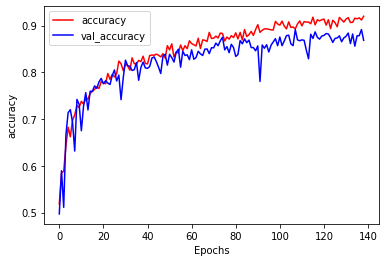

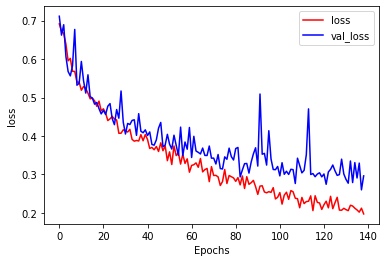

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  epochs = range(len(history.history[string]))
  plt.plot(epochs, history.history[string], 'r', label=string)
  plt.plot(epochs, history.history['val_'+string], 'b', label=string+'_val')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## 4. Visualisasi Konvolusi

Berikut adalah proses konvolusi yang terjadi di tiap layernya.

Untuk maxpooling, terlihat ukuran gambar mengecil menjadi 1/4 ukuran sebelum operasi citra maxpooling.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


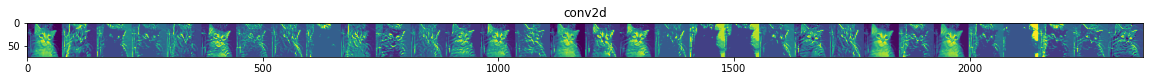

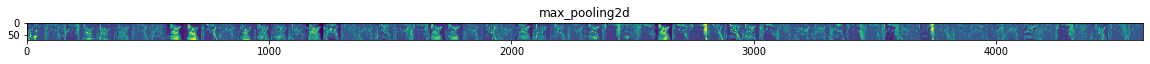

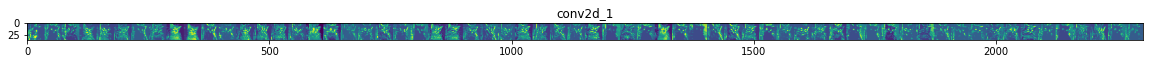

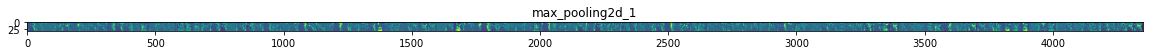

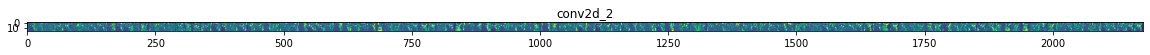

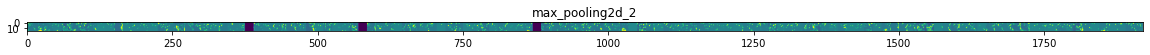

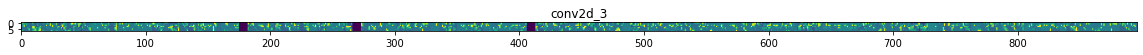

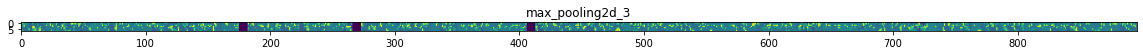

In [13]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(cats_dir, f) for f in cat_fnames]
dog_img_files = [os.path.join(dogs_dir, f) for f in dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    # display_grid = np.zeros((size, size * n_features * 5))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = (20. / n_features)
    plt.figure( figsize=(scale * n_features, scale) )
    # plt.figure( figsize=(20, 20) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 
    # plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

## Prediksi Gambar

Saving cat4.png to cat4.png
Saving dog2.png to dog2 (2).png


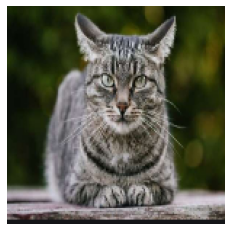

[[0.]]

Hasil prediksi: Kucing



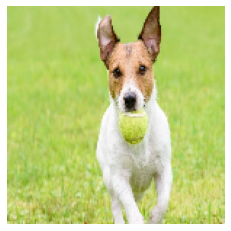

[[1.]]

Hasil prediksi: Anjing



In [19]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(150,150))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes) # Prediksi kelas tersimpan dalam array
  # Keluaran Prediksi
  print('\nHasil prediksi:', end=' ')
  if classes[0][0] == 0:
    print('Kucing\n')
  else:
    print('Anjing\n')

## 5. Model Baru (Menggunakan Augmentasi)

In [ ]:
model_aug = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_aug.summary()

model_aug.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

## 6. Generator untuk Augmentasi

ImageDataGenerator membantu augmentasi gambar terhadap pelatihan model. Sehingga, ketika pelatihan, model lebih banyak belajar terhadap berbagai kemungkinan yang dihadapi ketika proses validasi.

In [ ]:
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset = 'training')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        subset = 'validation')

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


## 7. Pelatihan

In [ ]:
history2 = model_aug.fit(
      train_generator,
      steps_per_epoch=100,  
      epochs=150,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=100,
      callbacks = [callbacks])

Epoch 1/150
100/100 [==============================] - 31s 306ms/step - loss: 0.6966 - accuracy: 0.4964 - val_loss: 0.6888 - val_accuracy: 0.5120
Epoch 2/150
100/100 [==============================] - 30s 304ms/step - loss: 0.6872 - accuracy: 0.5419 - val_loss: 0.6915 - val_accuracy: 0.5295
Epoch 3/150
100/100 [==============================] - 30s 298ms/step - loss: 0.6773 - accuracy: 0.5903 - val_loss: 0.6559 - val_accuracy: 0.6145
Epoch 4/150
100/100 [==============================] - 29s 287ms/step - loss: 0.6612 - accuracy: 0.5897 - val_loss: 0.6565 - val_accuracy: 0.5800
Epoch 5/150
100/100 [==============================] - 28s 285ms/step - loss: 0.6616 - accuracy: 0.6073 - val_loss: 0.6177 - val_accuracy: 0.6570
Epoch 6/150
100/100 [==============================] - 28s 282ms/step - loss: 0.6360 - accuracy: 0.6419 - val_loss: 0.6210 - val_accuracy: 0.6465
Epoch 7/150
 40/100 [===========>..................] - ETA: 8s - loss: 0.6216 - accuracy: 0.6335

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

100/100 [==============================] - 28s 284ms/step - loss: 0.6288 - accuracy: 0.6240 - val_loss: 0.6132 - val_accuracy: 0.6550
Epoch 8/150
100/100 [==============================] - 28s 283ms/step - loss: 0.6250 - accuracy: 0.6528 - val_loss: 0.6017 - val_accuracy: 0.6680
Epoch 9/150
100/100 [==============================] - 28s 281ms/step - loss: 0.6282 - accuracy: 0.6290 - val_loss: 0.6058 - val_accuracy: 0.6545
Epoch 10/150
100/100 [==============================] - 28s 281ms/step - loss: 0.6222 - accuracy: 0.6355 - val_loss: 0.6807 - val_accuracy: 0.6035
Epoch 11/150
100/100 [==============================] - 28s 281ms/step - loss: 0.6038 - accuracy: 0.6813 - val_loss: 0.5920 - val_accuracy: 0.6900
Epoch 12/150
100/100 [==============================] - 28s 282ms/step - loss: 0.5883 - accuracy: 0.6706 - val_loss: 0.6019 - val_accuracy: 0.6730
Epoch 13/150
100/100 [==============================] - 28s 284ms/step - loss: 0.6087 - accuracy: 0.6361 - val_loss: 0.5923 - val_acc

### Grafik Pelatihan

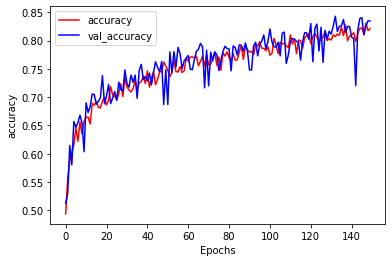

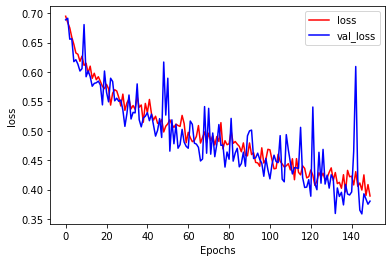

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")